In [2]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
mvg_data_orig = pd.read_parquet("../../data/subway_only_dedup.parquet")

In [18]:
mvg_data = mvg_data_orig

mvg_data = mvg_data.drop(columns=['transportType', 'realtimeDepartureTime', 'timestamp'])
mvg_data = mvg_data[mvg_data.realtime]
mvg_data['onTime'] = mvg_data['delayInMinutes'] == 0

mvg_datetime = pd.to_datetime(mvg_data['plannedDepartureTime']).dt

mvg_data['hourOfDay'] = mvg_datetime.hour
mvg_data['minuteOfDay'] = mvg_datetime.hour * 60 + mvg_datetime.minute
mvg_data['dayOfWeek'] = mvg_datetime.day_of_week # Monday=0, Sunday=6
mvg_data['dayOfYear'] = mvg_datetime.day_of_year

mvg_data = mvg_data.head(100_000)

mvg_data

,station,plannedDepartureTime,realtime,delayInMinutes,label,destination,onTime,hourOfDay,minuteOfDay,dayOfWeek,dayOfYear
0,de:09162:130,2025-06-10 05:57:00+00:00,True,0,U2,Feldmoching,True,5,357,1,161
1,de:09162:130,2025-06-10 05:58:00+00:00,True,0,U2,Messestadt Ost,True,5,358,1,161
2,de:09162:130,2025-06-10 06:02:00+00:00,True,-1,U2,Feldmoching,False,6,362,1,161
3,de:09162:130,2025-06-10 06:03:00+00:00,True,0,U2,Messestadt Ost,True,6,363,1,161
4,de:09162:130,2025-06-10 06:07:00+00:00,True,0,U2,Feldmoching,True,6,367,1,161
...,...,...,...,...,...,...,...,...,...,...,...
133130,de:09162:1,2024-03-05 08:35:00+00:00,True,0,U5,Neuperlach Süd,True,8,515,1,65
133131,de:09162:1,2024-03-05 08:39:00+00:00,True,0,U5,Laimer Platz,True,8,519,1,65
133132,de:09162:1,2024-03-05 08:39:00+00:00,True,1,U5,Neuperlach Süd,False,8,519,1,65
133133,de:09162:1,2024-03-05 08:41:00+00:00,True,0,U4,Theresienwiese,True,8,521,1,65


In [19]:
features = mvg_data.drop(['delayInMinutes', 'onTime', 'plannedDepartureTime'], axis=1)
target = mvg_data['onTime']

features_encoded = pd.get_dummies(features)

print("Original features columns:", features.columns.tolist())
print("Encoded features columns:", features_encoded.columns.tolist())

X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)


Original features columns: ['station', 'realtime', 'label', 'destination', 'hourOfDay', 'minuteOfDay', 'dayOfWeek', 'dayOfYear']
Encoded features columns: ['realtime', 'hourOfDay', 'minuteOfDay', 'dayOfWeek', 'dayOfYear', 'station_de:09162:1', 'station_de:09162:130', 'station_de:09162:1330', 'station_de:09162:280', 'station_de:09162:560', 'station_de:09162:570', 'label_3_:', 'label_U2', 'label_U4', 'label_U5', 'label_U6', 'label_U8', 'destination_', 'destination_Arabellapark', 'destination_Feldmoching', 'destination_Fröttmaning', 'destination_Garching, Forschungszentrum', 'destination_Giesing (Bahnhof)', 'destination_Karlsplatz (Stachus)', 'destination_Kieferngarten', 'destination_Klinikum Großhadern', 'destination_Laimer Platz', 'destination_Messestadt Ost', 'destination_Moosach', 'destination_Münchner Freiheit', 'destination_Neuperlach Süd', 'destination_Neuperlach Zentrum', 'destination_Olympiazentrum', 'destination_Scheidplatz', 'destination_Sendlinger Tor', 'destination_Theresienw

In [20]:
training_results = {}
validation_results = {}

for k in range(1,200,3):
    # Modell definieren und trainieren
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Modell auf Trainings- und Validierungsgenauigkeit testen
    training_results[k] = knn.score(X_train, y_train)
    validation_results[k] = (knn.predict(X_val) == y_val).mean()

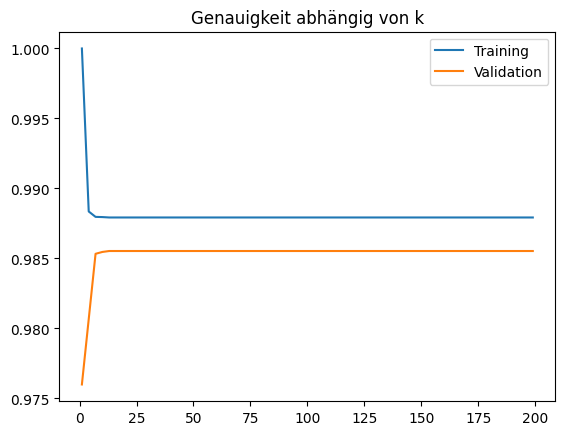

: 

In [ ]:
x, y = zip(*training_results.items())
plt.plot(x, y, label="Training")
x, y = zip(*validation_results.items())
plt.plot(x, y, label="Validation")

plt.title("Genauigkeit abhängig von k")
plt.legend()
plt.show()